In [1]:
from math import ceil, log, floor
from pathlib import Path
import pandas as pd
import numpy as np
from random import randint
import csv
from sys import getsizeof
from collections.abc import Generator, Callable

What data do I want to retrieve from all the files?

Looping through all the files, I can aggregate data from each file.
Each row has a bike ID which gives it a distinctive quality.
Values are:
   - Lat, Lng pairs for start and end
   - Starting and ending datetime
Categories are:
   - Bike type (Electric: True, Classic: False)
   - Member type (Member: True, Casual: False)
   - Stating and ending station name or float ID

Potential routes are:
   - Create storage 

In [2]:
dir_main = Path('/Users/neelagarwal/Desktop/CITIBike Data/')
dir_nyc = dir_main / 'NYC'
dir_jersey = dir_main / 'Jersey'

def iter_subfiles(parent: Path, year: int):
    dir_year = parent / f'{year}'

    if parent.stem == 'NYC':
        for dir_month in dir_year.iterdir():
            dir_month: Path
            if dir_month.is_dir():
                for csv in dir_month.iterdir():
                    csv: Path
                    if csv.is_file() and csv.suffix == '.csv':
                        yield csv.resolve()
                        
    elif parent.stem == 'Jersey':
        for csv in dir_year.iterdir():
            csv: Path
            if csv.is_file() and csv.suffix == '.csv':
                yield csv.resolve()

def csv_generator(parent, year):
    for file in iter_subfiles(parent, year):
        yield pd.read_csv(file, low_memory = False)

def csv_to_df(parent: Path, year: int, selected_file_num: int | None = None, just_headers: bool = False) -> Generator[pd.DataFrame] | pd.DataFrame | str:
    if selected_file_num is None:
        return csv_generator(parent, year)
    elif selected_file_num is not None:
        for num, file in enumerate(iter_subfiles(parent, year)):
            if num == selected_file_num:
                if just_headers:
                    with open(file) as f:
                        csv_reader = csv.reader(f)
                        return next(csv_reader)
                elif not just_headers:
                    return pd.read_csv(file, low_memory = False)


def generate_randint(start: int, stop: int):
    while True:
        yield randint(start, stop)

random_int = generate_randint(0, 2)

def get_all_columns(parent: Path, years: list[int]):
    all_cols = [csv_to_df(parent, year, next(random_int), just_headers = True) for year in years]
    return [(list(cols) if cols else None) for cols in all_cols]

def digits_in_words(digits: int):
    term = str(len(str(digits)))
    stmt_map = {
        '0': 'None'
        ,'1': 'Ones'
        ,'2': 'Tens'
        ,'3': 'Hundreds'
        ,'4': 'Thousands'
        ,'5': 'Tens of thousands'
        ,'6': 'Hundreds of thousands'
        ,'7': 'Millions'
        ,'8': 'Tens of millions'
        ,'9': 'Hundreds of millions'
        ,'10': 'Billions'
        ,'11': 'Tens of billions'
        ,'12': 'Hundreds of billions'
        ,'13': 'Trillions'
        ,'14': 'Tens of trillions'
        ,'15': 'Hundreds of trillions'
    }
    return stmt_map.get(term, 'None')

def convert_size(size_bytes):
    if size_bytes == 0:
        return '0B'
    size_name = ('B', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB', 'ZB', 'YB')
    i = int(floor(log(size_bytes, 1024)))
    p = 1024**i
    s = round(size_bytes / p, 2)
    return '%s %s' % (s, size_name[i])

def size_stmt_from_size(size: int):
    print(
        f'Bytes: {size}\n'
        f'Digits: {digits_in_words(size)}\n'
        f'Simplified: {convert_size(size)}'
    )
    return size

def size_stmt_delta(size: int):
    print('*DELTA SIZE*')
    size_stmt_from_size(size)
    return None

def size_stmt_from_df(df: pd.DataFrame):
    size = getsizeof(df)
    size_stmt_from_size(size)
    return size

In [40]:
# years = list(range(2013, 2017)) + list(range(2023, 2026))
# for col_set, year in zip(get_all_columns(dir_nyc, years), years):
#     print(f'{year} ({len(col_set)}): {col_set}')

In [41]:
# years = [2016, 2023, 2024, 2025]
# for i in zip(get_all_columns(dir_jersey, years), years):
#     print(f'{year} ({len(col_set)}): {col_set}')

In [5]:
df = csv_to_df(dir_nyc, 2014, 1)
df2 = csv_to_df(dir_nyc, 2024, 1)

In [6]:
def haversine_vectorized(lat1: pd.Series, lng1: pd.Series, lat2: pd.Series, lng2: pd.Series, unit = 'km' or 'mi') -> pd.Series:
    lat1, lng1, lat2, lng2 = map(np.radians, [lat1, lng1, lat2, lng2])
    delta_lat = lat2 - lat1
    delta_lng = lng2 - lng1
    a = (np.sin(delta_lat / 2.0)) ** 2 + np.cos(lat1) * np.cos(lat2) * (np.sin(delta_lng / 2.0)) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    if unit == 'km':
        R = 6371
    elif unit == 'mi':
        R = 3959
    result: pd.Series
    result = R * c
    return result

In [ ]:
class Features:
    def __init__(self, df: pd.DataFrame):
        self.main_df = df.copy()
        # self.df_out = pd.DataFrame()
        self.station_csv = Path('station_data.csv')
        self.field_variations().value_mapping()
        self.clean_df().add_calculations()
        self.extract_and_normalize_stations()

    def field_variations(self):
        self.fields = ['bike_id', 'if_electric_bike'
            ,'start_dt', 'end_dt'
            ,'start_station', 'end_station'
            ,'start_id', 'end_id'
            ,'start_lat', 'start_lng'
            ,'end_lat', 'end_lng'
            ,'if_member'
        ]
        self.col_name_map = {
            'ride_id': 'bike_id'
            ,'bikeid':  'bike_id'

            ,'rideable_type': 'if_electric_bike'

            ,'started_at': 'start_dt'
            ,'starttime': 'start_dt'

            ,'ended_at': 'end_dt'
            ,'stoptime': 'end_dt'

            ,'start_station_name': 'start_station'
            ,'start station name': 'start_station'

            ,'end_station_name': 'end_station'
            ,'end station name': 'end_station'

            ,'start_station_id': 'start_id'
            ,'start station id': 'start_id'

            ,'end_station_id': 'end_id'
            ,'end station id': 'end_id'

            ,'start station latitude': 'start_lat'
            ,'start station longitude': 'start_lng'

            ,'end station latitude': 'end_lat'
            ,'end station longitude': 'end_lng'

            ,'member_casual': 'if_member'
            ,'usertype': 'if_member'
        }
        return self
    
    def value_mapping(self):
        self.bike_type_map = {'classic_bike': False, 'electric_bike': True}
        self.membership_map = {
            'casual': False, 'member': True,
            'Customer': False, 'Subscriber': True
        }
        return self
    
    def clean_df(self):
        self.main_df.dropna(how = 'any', inplace = True)
        self.main_df.rename(columns = self.col_name_map, inplace = True)
        if 'if_electric_bike' in list(self.main_df.columns):
            self.main_df['if_electric_bike'] = self.main_df['if_electric_bike'].map(self.bike_type_map).astype(bool)
        else:
            self.main_df['if_electric_bike'] = False
        self.main_df['if_member'] = self.main_df['if_member'].map(self.membership_map).astype(bool)

        self.main_df['start_dt'] = pd.to_datetime(self.main_df['start_dt'])
        self.main_df['end_dt'] = pd.to_datetime(self.main_df['end_dt'])

        self.main_df = self.main_df[self.fields].copy()
        return self

    def add_calculations(self):
        self.main_df['duration_sec'] = pd.to_timedelta(self.main_df['end_dt'] - self.main_df['start_dt']).dt.total_seconds()
        self.main_df.drop(columns = ['start_dt', 'end_dt'], inplace = True)
        unit = 'mi'
        self.main_df[f'distance_{unit}'] = haversine_vectorized(
            self.main_df['start_lat']
            ,self.main_df['start_lng']
            ,self.main_df['end_lat']
            ,self.main_df['end_lng']
            ,unit
        ).round(4)
        self.main_df.drop(columns = ['start_lat', 'start_lng', 'end_lat', 'end_lng'], inplace = True)
        return self
    
    def extract_and_normalize_stations(self):
        new_stations = pd.concat([self.main_df['start_station'], self.main_df['end_station']], axis = 0).drop_duplicates(keep = 'first')

        if self.station_csv.exists():
            station_data = pd.read_csv(self.station_csv)
            stations = pd.concat([station_data['name'], new_stations], axis = 0).drop_duplicates(keep = 'first')
        else:
            stations = new_stations
        stations = stations.to_list()

        station_ids = list(range(1, len(stations) + 1))
        id_mapping = {str(station): id for id, station in zip(station_ids, stations)}

        self.main_df['start_station'] = self.main_df['start_station'].map(id_mapping)
        self.main_df['end_station'] = self.main_df['end_station'].map(id_mapping)
        self.main_df.drop(columns = ['start_id', 'end_id'], inplace = True)
        self.station_table = pd.DataFrame({'id': station_ids, 'name': stations})
        self.station_table.to_csv(self.station_csv, header = True, index = False)
        return self
    
    def merged_stations_table(self, df: pd.DataFrame | None = None) -> pd.DataFrame:
        if df is not None:
            pass
        elif df is None:
            df = self.main_df
        return (
            df.merge(self.station_table, how = 'inner', left_on = 'start_station', right_on = 'id')
                .drop(columns = ['start_station', 'id']).rename(columns = {'name': 'start_station'})
                .merge(self.station_table, how = 'inner', left_on = 'end_station', right_on = 'id')
                .drop(columns = ['end_station', 'id']).rename(columns = {'name': 'end_station'})
        )
    def get_distance_per_station(self, df: pd.DataFrame | None = None, agg_func: Callable[[], pd.DataFrame] = pd.Series.sum) -> pd.Series:
        if df is not None:
            pass
        elif df is None:
            df = self.main_df
        distance_per_startStation = pd.DataFrame(df.groupby('start_station')['distance_mi'].agg(agg_func))
        distance_per_endStation = pd.DataFrame(df.groupby('end_station')['distance_mi'].agg(agg_func))
        distances_per_stations = distance_per_startStation.merge(distance_per_endStation, how = 'inner', left_index = True, right_index = True)
        distances_per_stations['total_distances'] = distances_per_stations['distance_mi_x'] + distances_per_stations['distance_mi_y']
        return distances_per_stations.iloc[:, 2]
    
    def get_station_freq(self, df: pd.DataFrame | None = None):
        if df is not None:
            pass
        elif df is None:
            df = self.main_df
        start_station_view = df.groupby('start_station')['bike_id'].count()
        end_station_view = df.groupby('end_station')['bike_id'].count()
        view = pd.concat([start_station_view, end_station_view], axis = 1)
        view.fillna(0, inplace = True)
        view['station_freq'] = view.iloc[:, 0] + view.iloc[:, 1]
        return view['station_freq'].astype(int).copy()
    
    def add_to_csv(self, path: Path, data: list | tuple, time_period: str | int):
        if path.exists():
            existing_data = pd.read_csv(path, low_memory = False)
            existing_data[str(time_period)] = data
        else:
            ...

In [108]:
feats = Features(df2)

In [109]:
feats.main_df

,bike_id,if_electric_bike,start_station,end_station,if_member,duration_sec,distance_mi
0,75ED6A1CEC6F6636,True,1,672,True,1972.539,0.8280
1,D00A49B59C5EFFF1,True,2,668,True,738.615,1.5501
2,1F87CC628E7E55C1,True,3,671,True,694.902,2.0082
3,F2F01723369902DB,True,4,747,True,609.576,2.5734
4,C58E30448A6EFB1C,True,5,677,False,1036.155,3.4416
...,...,...,...,...,...,...,...
999995,582AEF751D07E73A,False,1224,1312,False,3711.292,2.2069
999996,5794D9D6DE695385,True,1223,1315,True,837.075,1.8519
999997,266D44B57FC1D93F,False,1486,2003,True,142.776,0.3367
999998,CFCBA80BD6CD250F,True,1224,1312,True,594.459,2.2069


In [ ]:
feats.main_df.sort_values('duration_sec', ascending = False).head()

In [43]:
feats.merged_stations_table(feats.main_df.sort_values('distance_mi', ascending = False).head())

,bike_id,if_electric_bike,if_member,duration_sec,distance_mi,start_station,end_station
0,EAA70A8C3D0280F1,True,True,856.722,5382.2897,New York Ave & St Marks Ave,Bronx WH station
1,CA8FC5C83468FC63,True,True,1497.953,5381.5182,Eastern Pkwy & Schenectady Ave,Bronx WH station
2,2E0BF31142BB7C36,True,True,1158.212,5381.5112,Schenectady Ave & President St,Bronx WH station
3,2E5F6890B42B2A54,True,True,6130.412,16.6118,Marble Hill Ave & W 227 St,47 St & 3 Ave
4,C7E176A9117EBE8E,True,True,6772.881,15.6096,Grand Concourse & E Mosholu Pkwy S,14 St & 5 Ave


,bike_id,if_electric_bike,if_member,duration_sec,distance_mi,start_station,end_station
0,75ED6A1CEC6F6636,True,True,1972.539,0.8280,E 128 St & Madison Ave,Frederick Douglass Blvd & W 117 St
1,D00A49B59C5EFFF1,True,True,738.615,1.5501,Thompson St & Bleecker St,South End Ave & Albany St
2,1F87CC628E7E55C1,True,True,694.902,2.0082,Queens Plaza North & Crescent St,E 43 St & Madison Ave
3,F2F01723369902DB,True,True,609.576,2.5734,9 St & 44 Rd,Shore Blvd & Astoria Park
4,C58E30448A6EFB1C,True,False,1036.155,3.4416,Sherman Ave & E 166 St,2 Ave & E 99 St
...,...,...,...,...,...,...,...
993266,582AEF751D07E73A,False,False,3711.292,2.2069,Central Park S & 6 Ave,5 Ave & E 103 St
993267,5794D9D6DE695385,True,True,837.075,1.8519,Graham Ave & Grand St,Putnam Ave & Throop Ave
993268,266D44B57FC1D93F,False,True,142.776,0.3367,St Johns Pl & Utica Ave,Carroll St & Rochester Ave
993269,CFCBA80BD6CD250F,True,True,594.459,2.2069,Central Park S & 6 Ave,5 Ave & E 103 St


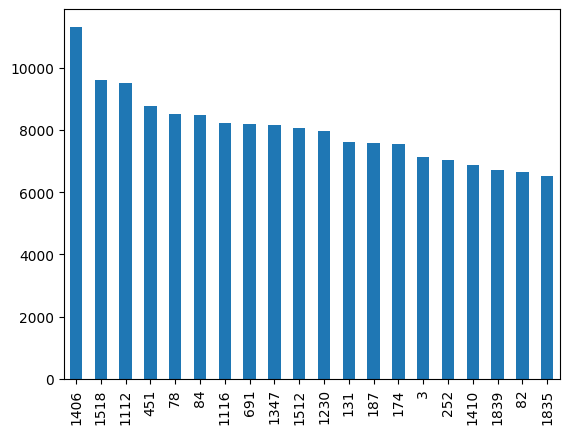

In [ ]:
save = feats.get_station_freq()
save.sort_values(ascending = False).head(20).plot.bar()

In [32]:
size_stmt_from_df(feats.main_df.drop(columns = ['bike_id']))

Bytes: 41717414
Digits: Tens of millions
Simplified: 39.78 MB


41717414

In [39]:
feats.get_distance_per_station()

1        1180.1865
2        6800.6951
3       10634.1147
4        1545.7246
5         625.5306
           ...    
2124      101.3545
2125       30.8983
2126        3.6718
2127       20.4147
2128       87.8954
Name: total_distances, Length: 2096, dtype: float64

In [ ]:
df = pd.DataFrame()

chunk_size = int(1e5)
size = df.shape[0]
num_chunks = ceil(size / chunk_size)

df_chunks = []
for i in range(num_chunks):
    chunk = df.loc[i * size : (i+1) * size]
    df_chunks.append(chunk)

In [ ]:
test_df = pd.DataFrame()

for df in df_chunks:
    test_df = pd.concat([test_df, df])

In [ ]:
test_df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,5511719F60A614AA,classic_bike,2023-07-10 20:07:52.959,2023-07-10 20:20:16.918,E 27 St & Park Ave S,6131.13,1 Ave & E 39 St,6303.01,40.742752,-73.984716,40.747140,-73.971130,casual
1,0747E080C54F7AAE,classic_bike,2023-07-17 15:30:30.216,2023-07-17 15:33:10.123,South St & Gouverneur Ln,4953.04,Maiden Ln & Pearl St,5065.10,40.703554,-74.006702,40.707065,-74.007319,member
2,1243D8C21B002936,classic_bike,2023-07-30 16:21:26.583,2023-07-30 16:38:17.095,South St & Gouverneur Ln,4953.04,St Marks Pl & 2 Ave,5669.10,40.703554,-74.006702,40.728419,-73.987140,member
3,82B9DB6B37D6104F,classic_bike,2023-07-31 17:22:49.480,2023-07-31 17:33:48.668,Forsyth St & Canal St,5270.07,Maiden Ln & Pearl St,5065.10,40.715815,-73.994224,40.707065,-74.007319,member
4,23E978F5180198F1,classic_bike,2023-07-11 18:25:52.841,2023-07-11 18:36:15.167,34 Ave & 45 St,6596.10,31 St & 23 Ave,7144.01,40.754795,-73.917014,40.774788,-73.912555,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
659576,832CA1B4855C70A5,electric_bike,2023-07-13 05:27:33.831,2023-07-13 05:54:28.704,Irving Ave & Harman St,4856.05,48 St & Broadway,6629.06,40.700916,-73.918112,40.755763,-73.912715,member
659577,8557BC1F7CCA1C6A,electric_bike,2023-07-11 19:06:35.962,2023-07-11 19:12:58.083,Madison St & Clinton St,5190.07,Canal St & Rutgers St,5303.08,40.712663,-73.987653,40.714275,-73.989900,member
659578,BE271830E3562BE2,electric_bike,2023-07-17 17:09:37.585,2023-07-17 17:15:17.400,N Moore St & Hudson St,5470.02,Liberty St & Broadway,5105.01,40.719961,-74.008443,40.709056,-74.010434,member
659579,90C7E9A95C19F0EA,electric_bike,2023-07-25 15:17:57.952,2023-07-25 15:21:48.394,N Moore St & Hudson St,5470.02,Liberty St & Broadway,5105.01,40.719931,-74.008355,40.709056,-74.010434,member
